<a href="https://colab.research.google.com/github/anastasiya-h79/AI_diplom_Weeds_classification_CNN/blob/main/ai_diplom_weeds_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
pip install keras==2.2.4

     |████████████████████████████████| 317kB 8.0MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/diplom_ns2/images.zip"  

Archive:  /content/drive/My Drive/diplom_ns2/images.zip
   creating: images/
  inflating: images/202011121-0.jpeg  
  inflating: images/202011121-2.jpg  
  inflating: images/202011121-3.jpg  
  inflating: images/202011121-4.jpg  
  inflating: images/2020111210-2.jpg  
  inflating: images/2020111210-3.jpg  
  inflating: images/2020111210-4.jpg  
 extracting: images/20201112100-0.jpeg  
  inflating: images/20201112100-2.jpeg  
  inflating: images/20201112100-3.jpg  
  inflating: images/20201112100-4.jpeg  
  inflating: images/20201112101-0.jpeg  
  inflating: images/20201112101-2.jpeg  
  inflating: images/20201112101-3.jpg  
 extracting: images/20201112101-4.jpeg  
  inflating: images/20201112102-0.jpeg  
 extracting: images/20201112102-2.png  
 extracting: images/20201112102-3.jpeg  
  inflating: images/20201112102-4.jpeg  
  inflating: images/20201112103-0.jpeg  
 extracting: images/20201112103-2.png  
 extracting: images/20201112103-3.jpg  
  inflating: images/20201112103-4.jpeg  
  

In [ ]:
!unzip "/content/drive/My Drive/diplom_ns2/labels.zip"

Archive:  /content/drive/My Drive/diplom_ns2/labels.zip
   creating: labels/
  inflating: labels/labels.csv       
  inflating: labels/train_subset0.csv  
  inflating: labels/train_subset1.csv  
  inflating: labels/val_subset0.csv  
  inflating: labels/val_subset1.csv  


In [ ]:
!ls

drive  images  labels  sample_data


In [ ]:
import argparse
import os
from zipfile import ZipFile
from urllib.request import urlopen
import shutil
import pandas as pd
from time import time
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, Adamax, Ftrl, Nadam, RMSprop, SGD

from tensorflow.keras.preprocessing import image
#from tensorflow.keras.utils import layer_utils
#from tensorflow.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
#from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
#from resnets_utils import *
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

from PIL import Image, ImageDraw, ImageFont
#import matplotlib.pyplot as plt



import csv
from tensorflow.keras.models import Model, load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow

# Global paths
OUTPUT_DIRECTORY = "/content/outputs/"
LABEL_DIRECTORY = "/content/labels/" 
MODEL_GD_ID = "1MRbN5hXOTYnw7-71K-2vjY01uJ9GkQM5"
MODEL_DIRECTORY = "/content/models/"
MODEL_URL = "https://nextcloud.qriscloud.org.au/index.php/s/Y7EhlkVMYCqxdg2/download"
#MODEL_URL = "https://drive.google.com/file/d/1XM-eBOUupo46DGODfDlHQb61hTv8Rh0k/view?usp=sharing" 
MODEL_ZIP_FILE = "/content/models/models.zip"
IMG_DIRECTORY = "/content/images/"
#IMG_ZIP_FILE = "/content/images.zip"


# Global variables
RAW_IMG_SIZE = (256, 256)
IMG_SIZE = (224, 224)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
MAX_EPOCH = 40
BATCH_SIZE = 32
FOLDS = 2
STOPPING_PATIENCE = 16
LR_PATIENCE = 16
INITIAL_LR = 0.0001
CLASSES = ['0', '1', '2', '3', '4']
CLASSES_ = [0, 1, 2, 3, 4]
CLASS_NAMES = ['Pyrej',
               'Proso',
               'Shirica',
               'Osot',
               'Svekla']

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
!pip install requests
import requests

In [ ]:
def download_google_drive_file(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768    #запись ответа кусками

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


def download_models():
    if not os.path.exists(MODEL_DIRECTORY):
        os.makedirs(MODEL_DIRECTORY)
        print("Downloading models to " + MODEL_ZIP_FILE)
        download_google_drive_file(MODEL_GD_ID, MODEL_ZIP_FILE)
        print("Finished downloading models.")
        print("Unzipping " + MODEL_ZIP_FILE)
        with ZipFile(MODEL_ZIP_FILE, "r") as zip_ref:
            zip_ref.extractall(MODEL_DIRECTORY)
        print("Finished unzipping models.")
download_models()

Finished downloading models.
Unzipping /content/models/models.zip
Finished unzipping models.


In [ ]:
def crop(img, size):
    """
    Crop the image concentrically to the desired size.
    :param img: Input image
    :param size: Required crop image size
    :return:
    """
    (h, w, c) = img.shape
    x = int((w - size[0]) / 2)
    y = int((h - size[1]) / 2)
    return img[y:(y + size[1]), x:(x + size[0]), :]


def crop_generator(batches, size):
    """
    Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator
    :param batches: Batches of images to be cropped
    :param size: Size to be cropped to
    :return:
    """
    while True:
        batch_x, batch_y = next(batches)
        (b, h, w, c) = batch_x.shape
        batch_crops = np.zeros((b, size[0], size[1], c))
        for i in range(b):
            batch_crops[i] = crop(batch_x[i], (size[0], size[1]))
        yield (batch_crops, batch_y)

# multi label classification 



In [ ]:

def cross_validate(model_name):

    # K fold cross validation, saving outputs for each fold
    for k in range(FOLDS):

        # Create new output directory for individual folds from timestamp
        timestamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')
        print('Fold {}/{} - {}'.format(k + 1, FOLDS, timestamp))
        output_directory = "{}{}/".format(OUTPUT_DIRECTORY, timestamp)
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        # Prepare training, validation and testing labels for kth fold
        train_label_file = "{}train_subset{}.csv".format(LABEL_DIRECTORY, k)
        val_label_file = "{}val_subset{}.csv".format(LABEL_DIRECTORY, k)
        #test_label_file = "{}test_subset{}.csv".format(LABEL_DIRECTORY, k)
        train_dataframe = pd.read_csv(train_label_file, dtype='str')
        val_dataframe = pd.read_csv(val_label_file, dtype='str')
        

        train_image_count = train_dataframe.shape[0]
        val_image_count = train_dataframe.shape[0]


        # Training image augmentation
        train_data_generator = ImageDataGenerator(
            rescale=1. / 255,
            fill_mode="constant",
            shear_range=0.2,
            zoom_range=(0.5, 1),
            horizontal_flip=True,
            rotation_range=360,
            channel_shift_range=25,
            brightness_range=(0.75, 1.25))

        # Validation image augmentation
        val_data_generator = ImageDataGenerator(
            rescale=1. / 255,
            fill_mode="constant",
            shear_range=0.2,
            zoom_range=(0.5, 1),
            horizontal_flip=True,
            rotation_range=360,
            channel_shift_range=25,
            brightness_range=(0.75, 1.25))


        # Load train images in batches from directory and apply augmentations
        train_data_generator = train_data_generator.flow_from_dataframe(
            train_dataframe,
            IMG_DIRECTORY,
            x_col="Filename",
            y_col="Label",
            target_size=RAW_IMG_SIZE,
            batch_size=BATCH_SIZE,
            has_ext=True,
            classes=CLASSES,
            class_mode='categorical')

        # Load validation images in batches from directory and apply rescaling
        val_data_generator = val_data_generator.flow_from_dataframe(
            val_dataframe,
            IMG_DIRECTORY,
            x_col="Filename",
            y_col="Label",
            target_size=RAW_IMG_SIZE,
            batch_size=BATCH_SIZE,
            has_ext=True,
            classes=CLASSES, 
            class_mode='categorical')


        # Crop augmented images from 256x256 to 224x224
        train_data_generator = crop_generator(train_data_generator, IMG_SIZE)
        val_data_generator = crop_generator(val_data_generator, IMG_SIZE)
    

        # Load ImageNet pre-trained model with no top, either InceptionV3 or ResNet50
        if model_name == "resnet":
            base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        elif model_name == "inception":
            base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
        x = base_model.output
        #x = models.load_model('content/DeepWeeds/lastbest-0-1.hdf5', backbone_name='lastbest-0-1')(x)
        #x = resblock(x)
        # Add a global average pooling layer
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        # Add fully connected output layer with sigmoid activation for multi label classification
        outputs = Dense(len(CLASSES), activation='sigmoid', name='fc9')(x)
        # Assemble the modified model
        model = Model(inputs=base_model.input, outputs=outputs)

        #model.summary()

        # Checkpoints for training
        model_checkpoint = ModelCheckpoint(output_directory + "lastbest-0.hdf5", verbose=1, save_best_only=True)
        early_stopping = EarlyStopping(patience=STOPPING_PATIENCE, restore_best_weights=True)
        tensorboard = TensorBoard(log_dir=output_directory, histogram_freq=0, write_graph=True, write_images=False)
        reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=LR_PATIENCE, min_lr=0.000003125)
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=INITIAL_LR), metrics=['categorical_accuracy'])
        csv_logger = CSVLogger(output_directory + "training_metrics.csv")

        # Train model until MAX_EPOCH, restarting after each early stop when learning has plateaued
        global_epoch = 0
        restarts = 0
        last_best_losses = []
        last_best_epochs = []
        while global_epoch < MAX_EPOCH:
            history = model.fit_generator(
                generator=train_data_generator,
                steps_per_epoch=train_image_count // BATCH_SIZE,
                epochs=MAX_EPOCH - global_epoch,
                validation_data=val_data_generator,
                validation_steps=val_image_count // BATCH_SIZE,
                callbacks=[tensorboard, model_checkpoint, early_stopping, reduce_lr, csv_logger],
                shuffle=False)
            plt.plot(history.history['categorical_accuracy'], 
                    label='Доля верных ответов на обучающем наборе')
            plt.plot(history.history['val_categorical_accuracy'], 
                    label='Доля верных ответов на проверочном наборе')
            plt.xlabel('Эпоха обучения')
            plt.ylabel('Доля верных ответов')
            plt.legend()
            plt.show()
            last_best_losses.append(min(history.history['val_loss']))
            last_best_local_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
            last_best_epochs.append(global_epoch + last_best_local_epoch)
            if early_stopping.stopped_epoch == 0:
                print("Completed training after {} epochs.".format(MAX_EPOCH))
                break
            else:
                global_epoch = global_epoch + early_stopping.stopped_epoch - STOPPING_PATIENCE + 1
                print("Early stopping triggered after local epoch {} (global epoch {}).".format(
                    early_stopping.stopped_epoch, global_epoch))
                print("Restarting from last best val_loss at local epoch {} (global epoch {}).".format(
                    early_stopping.stopped_epoch - STOPPING_PATIENCE, global_epoch - STOPPING_PATIENCE))
                restarts = restarts + 1
                model.compile(loss='binary_crossentropy', optimizer=Adam(lr=INITIAL_LR / 2 ** restarts),
                              metrics=['categorical_accuracy'])
                model_checkpoint = ModelCheckpoint(output_directory + "lastbest-{}.hdf5".format(restarts),
                                                   monitor='val_loss', verbose=1, save_best_only=True, mode='min')

        # Save last best model info
        with open(output_directory + "last_best_models.csv", 'w', newline='') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerow(['Model file', 'Global epoch', 'Validation loss'])
            for i in range(restarts + 1):
                writer.writerow(["lastbest-{}.hdf5".format(i), last_best_epochs[i], last_best_losses[i]])

        # Load the last best model
        model = load_model(
            output_directory + "lastbest-{}.hdf5".format(last_best_losses.index(min(last_best_losses))))

        # Evaluate model on test subset for kth fold
        predictions = model.predict_generator(val_data_generator, val_image_count // BATCH_SIZE + 1)
        y_true = val_data_generator.classes
        y_pred = np.argmax(predictions, axis=1)
        y_pred[np.max(predictions, axis=1) < 1 / 9] = 8  # Assign predictions worse than random guess to negative class

        # #Generate and print classification metrics and confusion matrix
        # print(classification_report(y_true, y_pred, labels=CLASSES_, target_names=CLASS_NAMES)) 
        # report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
        # with open(output_directory + 'classification_report.csv', 'w') as f:
        #     for key in report.keys():
        #         f.write("%s,%s\n" % (key, report[key]))
        # conf_arr = confusion_matrix(y_true, y_pred, labels=CLASSES_)
        # print(conf_arr)
        # np.savetxt(output_directory + "confusion_matrix.csv", conf_arr, delimiter=",")

        # Clear model from GPU after each iteration
        print("Finished testing fold {}\n".format(k + 1))
        K.clear_session()
        k = k + 1




Fold 1/2 - 20210411-151317
Found 1624 validated image filenames belonging to 5 classes.
Found 327 validated image filenames belonging to 5 classes.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 82 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 61 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


94773248/94765736 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40
53/53 [==============================] - 47s 889ms/step - loss: 0.1841 - categorical_accuracy: 0.8095

Epoch 00001: val_loss improved from inf to 0.18415, saving model to /content/outputs/20210411-151317/lastbest-0.hdf5
53/53 [==============================] - 109s 2s/step - loss: 0.2566 - categorical_accuracy: 0.7530 - val_loss: 0.1841 - val_categorical_accuracy: 0.8095
Epoch 2/40
53/53 [==============================] - 46s 862ms/step - loss: 0.1392 - categorical_accuracy: 0.8701

Epoch 00002: val_loss improved from 0.18415 to 0.13922, saving model to /content/outputs/20210411-151317/lastbest-0.hdf5
53/53 [==============================] - 83s 2s/step - loss: 0.0838 - categorical_accuracy: 0.9354 - val_loss: 0.1392 - val_categorical_accuracy: 0.8701
Epoch 3/40
53/53 [==============================] - 46s 861ms/step -

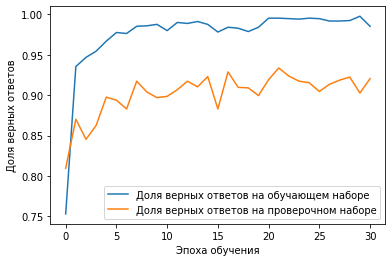

Early stopping triggered after local epoch 30 (global epoch 15).
Restarting from last best val_loss at local epoch 14 (global epoch -1).
Epoch 1/25
53/53 [==============================] - 46s 859ms/step - loss: 0.1005 - categorical_accuracy: 0.9338

Epoch 00001: val_loss improved from inf to 0.10054, saving model to /content/outputs/20210411-151317/lastbest-1.hdf5
53/53 [==============================] - 95s 2s/step - loss: 0.0095 - categorical_accuracy: 0.9923 - val_loss: 0.1005 - val_categorical_accuracy: 0.9338
Epoch 2/25
53/53 [==============================] - 46s 871ms/step - loss: 0.1107 - categorical_accuracy: 0.9273

Epoch 00002: val_loss did not improve from 0.10054
53/53 [==============================] - 81s 2s/step - loss: 0.0091 - categorical_accuracy: 0.9929 - val_loss: 0.1107 - val_categorical_accuracy: 0.9273
Epoch 3/25
53/53 [==============================] - 46s 875ms/step - loss: 0.1341 - categorical_accuracy: 0.9073

Epoch 00003: val_loss did not improve from 0.10

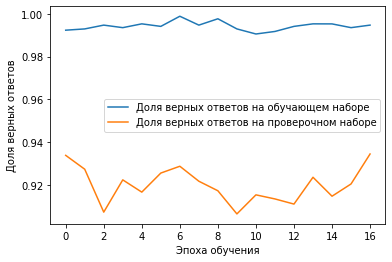

Early stopping triggered after local epoch 16 (global epoch 16).
Restarting from last best val_loss at local epoch 0 (global epoch 0).
Epoch 1/24
53/53 [==============================] - 46s 861ms/step - loss: 0.1054 - categorical_accuracy: 0.9293

Epoch 00001: val_loss improved from inf to 0.10543, saving model to /content/outputs/20210411-151317/lastbest-2.hdf5
53/53 [==============================] - 95s 2s/step - loss: 0.0076 - categorical_accuracy: 0.9935 - val_loss: 0.1054 - val_categorical_accuracy: 0.9293
Epoch 2/24
53/53 [==============================] - 46s 870ms/step - loss: 0.1003 - categorical_accuracy: 0.9313

Epoch 00002: val_loss improved from 0.10543 to 0.10028, saving model to /content/outputs/20210411-151317/lastbest-2.hdf5
53/53 [==============================] - 83s 2s/step - loss: 0.0046 - categorical_accuracy: 0.9976 - val_loss: 0.1003 - val_categorical_accuracy: 0.9313
Epoch 3/24
53/53 [==============================] - 45s 848ms/step - loss: 0.1143 - categoric

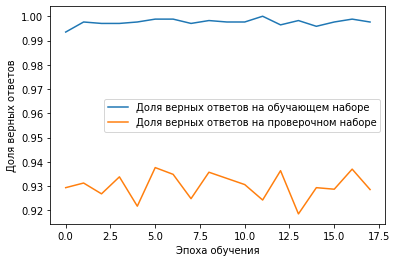

Early stopping triggered after local epoch 17 (global epoch 18).
Restarting from last best val_loss at local epoch 1 (global epoch 2).
Epoch 1/22
53/53 [==============================] - 46s 874ms/step - loss: 0.1117 - categorical_accuracy: 0.9311

Epoch 00001: val_loss improved from inf to 0.11171, saving model to /content/outputs/20210411-151317/lastbest-3.hdf5
53/53 [==============================] - 96s 2s/step - loss: 0.0039 - categorical_accuracy: 0.9982 - val_loss: 0.1117 - val_categorical_accuracy: 0.9311
Epoch 2/22
53/53 [==============================] - 46s 862ms/step - loss: 0.1157 - categorical_accuracy: 0.9313

Epoch 00002: val_loss did not improve from 0.11171
53/53 [==============================] - 81s 2s/step - loss: 0.0049 - categorical_accuracy: 0.9970 - val_loss: 0.1157 - val_categorical_accuracy: 0.9313
Epoch 3/22
53/53 [==============================] - 45s 855ms/step - loss: 0.1057 - categorical_accuracy: 0.9376

Epoch 00003: val_loss improved from 0.11171 to 0.

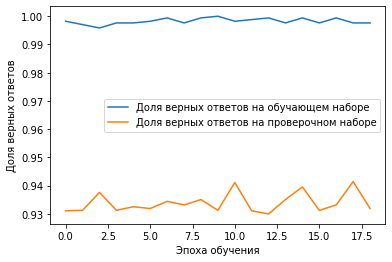

Early stopping triggered after local epoch 18 (global epoch 21).
Restarting from last best val_loss at local epoch 2 (global epoch 5).
Epoch 1/19
53/53 [==============================] - 46s 877ms/step - loss: 0.0990 - categorical_accuracy: 0.9357

Epoch 00001: val_loss improved from inf to 0.09903, saving model to /content/outputs/20210411-151317/lastbest-4.hdf5
53/53 [==============================] - 96s 2s/step - loss: 0.0031 - categorical_accuracy: 0.9988 - val_loss: 0.0990 - val_categorical_accuracy: 0.9357
Epoch 2/19
53/53 [==============================] - 45s 858ms/step - loss: 0.1038 - categorical_accuracy: 0.9370

Epoch 00002: val_loss did not improve from 0.09903
53/53 [==============================] - 82s 2s/step - loss: 0.0018 - categorical_accuracy: 1.0000 - val_loss: 0.1038 - val_categorical_accuracy: 0.9370
Epoch 3/19
53/53 [==============================] - 46s 866ms/step - loss: 0.1285 - categorical_accuracy: 0.9317

Epoch 00003: val_loss did not improve from 0.0990

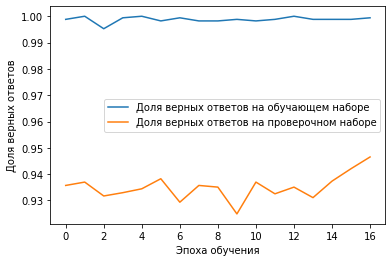

Early stopping triggered after local epoch 16 (global epoch 22).
Restarting from last best val_loss at local epoch 0 (global epoch 6).
Epoch 1/18
53/53 [==============================] - 46s 869ms/step - loss: 0.1000 - categorical_accuracy: 0.9376

Epoch 00001: val_loss improved from inf to 0.09999, saving model to /content/outputs/20210411-151317/lastbest-5.hdf5
53/53 [==============================] - 97s 2s/step - loss: 0.0033 - categorical_accuracy: 0.9994 - val_loss: 0.1000 - val_categorical_accuracy: 0.9376
Epoch 2/18
53/53 [==============================] - 46s 864ms/step - loss: 0.1057 - categorical_accuracy: 0.9389

Epoch 00002: val_loss did not improve from 0.09999
53/53 [==============================] - 81s 2s/step - loss: 0.0031 - categorical_accuracy: 0.9988 - val_loss: 0.1057 - val_categorical_accuracy: 0.9389
Epoch 3/18
53/53 [==============================] - 45s 845ms/step - loss: 0.1156 - categorical_accuracy: 0.9319

Epoch 00003: val_loss did not improve from 0.0999

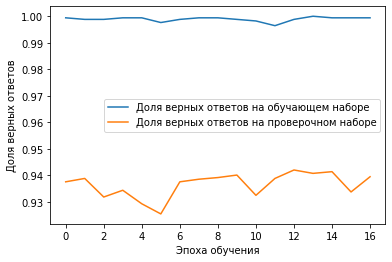

Early stopping triggered after local epoch 16 (global epoch 23).
Restarting from last best val_loss at local epoch 0 (global epoch 7).
Epoch 1/17
53/53 [==============================] - 47s 882ms/step - loss: 0.1133 - categorical_accuracy: 0.9274

Epoch 00001: val_loss improved from inf to 0.11333, saving model to /content/outputs/20210411-151317/lastbest-6.hdf5
53/53 [==============================] - 98s 2s/step - loss: 0.0020 - categorical_accuracy: 1.0000 - val_loss: 0.1133 - val_categorical_accuracy: 0.9274
Epoch 2/17
53/53 [==============================] - 46s 865ms/step - loss: 0.1162 - categorical_accuracy: 0.9367

Epoch 00002: val_loss did not improve from 0.11333
53/53 [==============================] - 81s 2s/step - loss: 0.0041 - categorical_accuracy: 0.9982 - val_loss: 0.1162 - val_categorical_accuracy: 0.9367
Epoch 3/17
53/53 [==============================] - 46s 865ms/step - loss: 0.1229 - categorical_accuracy: 0.9298

Epoch 00003: val_loss did not improve from 0.1133

KeyboardInterrupt: ignored

In [ ]:
cross_validate("resnet")


Fold 1/2 - 20210411-181132
Found 1624 validated image filenames belonging to 5 classes.
Found 327 validated image filenames belonging to 5 classes.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

87916544/87910968 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
53/53 [==============================] - 107s 2s/step - loss: 0.4646 - categorical_accuracy: 0.5730 - val_loss: 0.4865 - val_categorical_accuracy: 0.5815

Epoch 00001: val_loss improved from inf to 0.48650, saving model to /content/outputs/20210411-181132/lastbest-0.hdf5
Epoch 2/40
53/53 [==============================] - 82s 2s/step - loss: 0.1347 - categorical_accuracy: 0.8919 - val_loss: 0.2719 - val_categorical_accuracy: 0.7505

Epoch 00002: val_loss improved from 0.48650 to 0.27192, saving model to /content/outputs/20210411-181132/lastbest-0.hdf5
Epoch 3/40
53/53 [==============================] - 82s 2s/step - loss: 0.0807 - categorical_accuracy: 0.9447 - val_loss: 0.1556 - val_categorical_accuracy: 0.8498

Epoch 00003: val_loss improved from 0.27192 to 0.15563, saving model to /content/outputs/20210411-181132/lastbest-0.hdf5
Epoch 4/40
53/53 [==============================] - 83s 2s/step - loss: 0.0666 - categorical_accuracy: 0.9477 - val_loss: 0.1228 - val_categorica

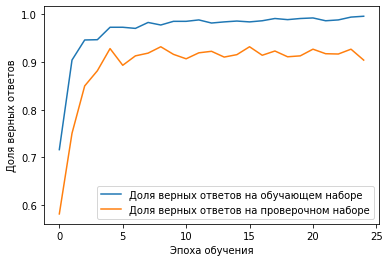

Early stopping triggered after local epoch 24 (global epoch 9).
Restarting from last best val_loss at local epoch 8 (global epoch -7).
Epoch 1/31
53/53 [==============================] - 90s 2s/step - loss: 0.0217 - categorical_accuracy: 0.9813 - val_loss: 0.0950 - val_categorical_accuracy: 0.9344

Epoch 00001: val_loss improved from inf to 0.09503, saving model to /content/outputs/20210411-181132/lastbest-1.hdf5
Epoch 2/31
53/53 [==============================] - 82s 2s/step - loss: 0.0156 - categorical_accuracy: 0.9907 - val_loss: 0.0865 - val_categorical_accuracy: 0.9313

Epoch 00002: val_loss improved from 0.09503 to 0.08653, saving model to /content/outputs/20210411-181132/lastbest-1.hdf5
Epoch 3/31
53/53 [==============================] - 82s 2s/step - loss: 0.0116 - categorical_accuracy: 0.9909 - val_loss: 0.0875 - val_categorical_accuracy: 0.9319

Epoch 00003: val_loss did not improve from 0.08653
Epoch 4/31
53/53 [==============================] - 82s 2s/step - loss: 0.0114 - 

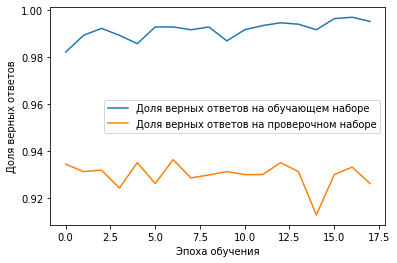

Early stopping triggered after local epoch 17 (global epoch 11).
Restarting from last best val_loss at local epoch 1 (global epoch -5).
Epoch 1/29
53/53 [==============================] - 92s 2s/step - loss: 0.0116 - categorical_accuracy: 0.9928 - val_loss: 0.0861 - val_categorical_accuracy: 0.9380

Epoch 00001: val_loss improved from inf to 0.08609, saving model to /content/outputs/20210411-181132/lastbest-2.hdf5
Epoch 2/29
53/53 [==============================] - 83s 2s/step - loss: 0.0143 - categorical_accuracy: 0.9904 - val_loss: 0.0888 - val_categorical_accuracy: 0.9342

Epoch 00002: val_loss did not improve from 0.08609
Epoch 3/29
53/53 [==============================] - 83s 2s/step - loss: 0.0110 - categorical_accuracy: 0.9955 - val_loss: 0.0834 - val_categorical_accuracy: 0.9402

Epoch 00003: val_loss improved from 0.08609 to 0.08336, saving model to /content/outputs/20210411-181132/lastbest-2.hdf5
Epoch 4/29
53/53 [==============================] - 82s 2s/step - loss: 0.0113 -

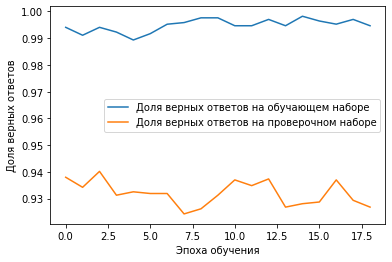

Early stopping triggered after local epoch 18 (global epoch 14).
Restarting from last best val_loss at local epoch 2 (global epoch -2).
Epoch 1/26
53/53 [==============================] - 91s 2s/step - loss: 0.0123 - categorical_accuracy: 0.9923 - val_loss: 0.0873 - val_categorical_accuracy: 0.9446

Epoch 00001: val_loss improved from inf to 0.08733, saving model to /content/outputs/20210411-181132/lastbest-3.hdf5
Epoch 2/26
53/53 [==============================] - 83s 2s/step - loss: 0.0116 - categorical_accuracy: 0.9940 - val_loss: 0.0809 - val_categorical_accuracy: 0.9363

Epoch 00002: val_loss improved from 0.08733 to 0.08094, saving model to /content/outputs/20210411-181132/lastbest-3.hdf5
Epoch 3/26
53/53 [==============================] - 83s 2s/step - loss: 0.0095 - categorical_accuracy: 0.9928 - val_loss: 0.0835 - val_categorical_accuracy: 0.9351

Epoch 00003: val_loss did not improve from 0.08094
Epoch 4/26
53/53 [==============================] - 82s 2s/step - loss: 0.0110 -

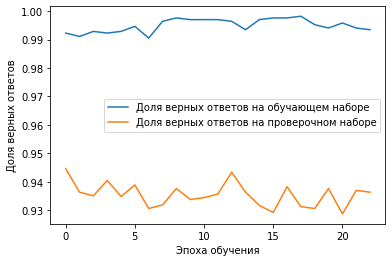

Early stopping triggered after local epoch 22 (global epoch 21).
Restarting from last best val_loss at local epoch 6 (global epoch 5).
Epoch 1/19
53/53 [==============================] - 90s 2s/step - loss: 0.0094 - categorical_accuracy: 0.9926 - val_loss: 0.0884 - val_categorical_accuracy: 0.9338

Epoch 00001: val_loss improved from inf to 0.08840, saving model to /content/outputs/20210411-181132/lastbest-4.hdf5
Epoch 2/19
53/53 [==============================] - 82s 2s/step - loss: 0.0053 - categorical_accuracy: 0.9970 - val_loss: 0.0856 - val_categorical_accuracy: 0.9370

Epoch 00002: val_loss improved from 0.08840 to 0.08557, saving model to /content/outputs/20210411-181132/lastbest-4.hdf5
Epoch 3/19
53/53 [==============================] - 82s 2s/step - loss: 0.0078 - categorical_accuracy: 0.9951 - val_loss: 0.0916 - val_categorical_accuracy: 0.9298

Epoch 00003: val_loss did not improve from 0.08557
Epoch 4/19
53/53 [==============================] - 83s 2s/step - loss: 0.0046 - 

In [ ]:
cross_validate("inception")